<h2> Spatial & Temporal MBA Data Tests </h2>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>
<br>
<h7>4/12/22</h7>


In [198]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [228]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
from google.cloud import bigquery


os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> SQL Queries

In [200]:
# 5th pct speed for windstream 50 mbps: peak = 29.8516, peak median = 42.628344 totalBoxes = 32
# 5th pct speed for windstream 100 mbps: nonpeak = 73.543872, peak = 74.440792, peak median= 100.593248 totalBoxes=34
# 5th pct speed for Comcast 500 mbps: nonpeak = 139.989232, peak = 195.859112, totalBoxes = 12
# 5th pct speed for Mediacom 500 mbps: nonpeak = 422.247576, peak = 393.978344, peak median =569.977616, totalboxes=43
# 5th pct speed for Frontier 500 mbps: nonpeak = 387.65412, peak = 350.104624, total boxes = 69




windstream50SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State, mt.Census,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= 29.8516 THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
WHERE mt.download = 50 AND mt.ISP = "Windstream" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census
ORDER BY LowSpeed5PctCount
"""


windstream100SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= 74.440792 THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
WHERE mt.download = 100 AND mt.ISP = "Windstream" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census 
ORDER BY LowSpeed5PctCount
"""

comcast500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State, mt.Census,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= 195.859112 THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
WHERE mt.download = 500 AND mt.ISP = "Comcast" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census
ORDER BY LowSpeed5PctCount
"""

mediacom500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State, mt.Census,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= 393.978344 THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
WHERE mt.download = 500 AND mt.ISP = "Mediacom" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census
ORDER BY LowSpeed5PctCount


"""

frontier500SQL = """
SELECT DISTINCT httpmt.unit_id, mt.ISP, mt.Technology, mt.Download,mt.State, mt.Census,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= 350.104624 THEN 1 ELSE 0 END) as LowSpeed5PctCount,
SUM(CASE WHEN httpmt.bytes_sec/125000 <= (mt.Download * .5) THEN 1 ELSE 0 END) as countBelow50PctSpeeds,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(5)] as slow5Pct,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(95)] as fastest95PctSpeedMbps,
APPROX_QUANTILES(httpmt.bytes_sec/125000, 100)[OFFSET(50)] as medianSpeedMbps,
FROM `broadband-data.mba_data.curr_httpgetmt` as httpmt 
    INNER JOIN`broadband-data.mba_data.unit-profile-sept2020` as mt
    ON httpmt.unit_id=mt.unit_id
WHERE mt.download = 500 AND mt.ISP = "Frontier" 
AND (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23)
GROUP BY  httpmt.unit_id, mt.ISP, mt.Technology, mt.Download, mt.State, mt.Census
ORDER BY LowSpeed5PctCount


"""


windstream50 = client.query(windstream50SQL).to_dataframe()
windstream100 = client.query(windstream100SQL).to_dataframe()
comcast500 = client.query(comcast500SQL).to_dataframe()
mediacom500 = client.query(mediacom500SQL).to_dataframe()
frontier500 = client.query(frontier500SQL).to_dataframe()

print('executed')



executed


In [201]:
# Creating new dataframes for scatter plots sorted by 95th consistent speed
windstream50['5PctNorm'] = windstream50['slow5Pct']/windstream50['Download']*100
windstream50['MedianNorm'] = windstream50['medianSpeedMbps']/windstream50['Download']*100
windstream50Scatter = windstream50.sort_values(by=['5PctNorm'], ascending = False)

windstream100['5PctNorm'] = windstream100['slow5Pct']/windstream100['Download']*100
windstream100['MedianNorm'] = windstream100['medianSpeedMbps']/windstream100['Download']*100
windstream100Scatter = windstream100.sort_values(by=['5PctNorm'], ascending = False)

comcast500['5PctNorm'] = comcast500['slow5Pct']/comcast500['Download']*100
comcast500['MedianNorm'] = comcast500['medianSpeedMbps']/comcast500['Download']*100
comcast500Scatter = comcast500.sort_values(by=['5PctNorm'], ascending = False)

mediacom500['5PctNorm'] = mediacom500['slow5Pct']/mediacom500['Download']*100
mediacom500['MedianNorm'] = mediacom500['medianSpeedMbps']/mediacom500['Download']*100
mediacom500Scatter = mediacom500.sort_values(by=['5PctNorm'], ascending = False)

frontier500['5PctNorm'] = frontier500['slow5Pct']/frontier500['Download']*100
frontier500['MedianNorm'] = frontier500['medianSpeedMbps']/frontier500['Download']*100
frontier500Scatter = frontier500.sort_values(by=['5PctNorm'], ascending = False)


In [202]:
windstream50Scatter

,unit_id,ISP,Technology,Download,State,Census,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,5PctNorm,MedianNorm
0,26226285,Windstream,DSL,50.0,GA,South,0,0,52.344768,52.424480,52.418480,104.689536,104.836960
13,999343,Windstream,DSL,50.0,MN,Midwest,0,0,51.168400,51.387288,51.354936,102.336800,102.709872
20,999339,Windstream,DSL,50.0,FL,South,2,0,48.411784,49.944944,49.900184,96.823568,99.800368
5,26226729,Windstream,DSL,50.0,OK,South,0,0,47.879080,48.383240,48.381888,95.758160,96.763776
14,1000117,Windstream,DSL,50.0,NY,Northeast,0,0,46.250992,50.061968,50.017472,92.501984,100.034944
11,1006178,Windstream,DSL,50.0,KY,South,0,0,45.366160,50.067784,50.005184,90.732320,100.010368
10,26226893,Windstream,DSL,50.0,NC,South,0,0,44.925960,46.407496,45.654560,89.851920,91.309120
12,26226221,Windstream,DSL,50.0,KY,South,0,0,44.887032,53.543520,53.462040,89.774064,106.924080
7,26226229,Windstream,DSL,50.0,NC,South,0,0,42.379960,48.378640,48.361680,84.759920,96.723360
4,573250,Windstream,DSL,50.0,PA,Northeast,0,0,41.283040,50.341496,47.150328,82.566080,94.300656


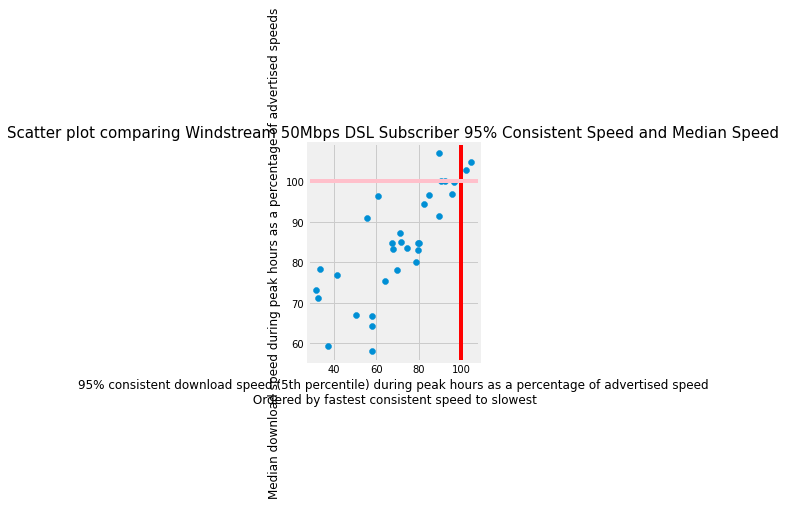

In [203]:
X =  windstream50Scatter['5PctNorm']
Y = windstream50Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.axhline(y = 100, color = 'pink', linestyle = '-')
ax1.scatter(X, Y)
plt.grid(True)


plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed\n Ordered by fastest consistent speed to slowest")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Windstream 50Mbps DSL Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

In [204]:
X

0     104.689536
13    102.336800
20     96.823568
5      95.758160
14     92.501984
11     90.732320
10     89.851920
12     89.774064
7      84.759920
4      82.566080
17     80.232560
15     79.941504
9      79.883600
6      78.978416
1      74.666064
2      71.945808
8      71.338736
23     69.691744
3      68.102544
16     67.620160
21     64.340064
19     60.675904
22     58.101104
18     57.942288
29     57.897680
31     55.837168
25     50.639456
26     41.609632
30     37.069264
27     33.544176
28     32.721120
24     31.377808
Name: 5PctNorm, dtype: float64

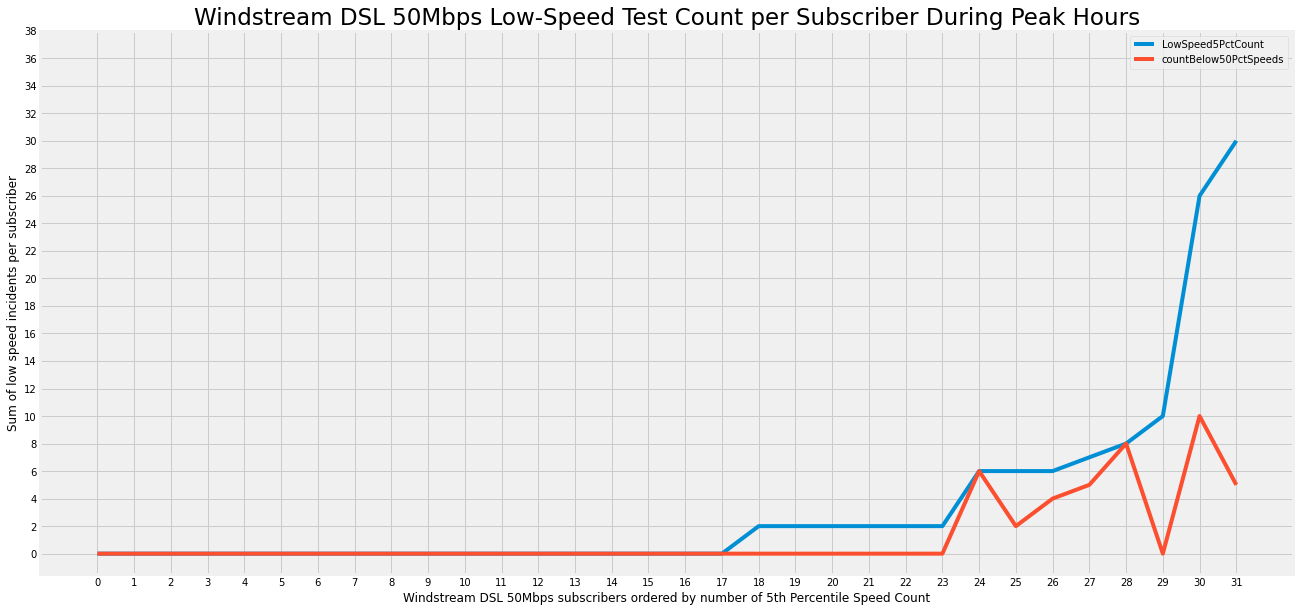

In [205]:
ax = windstream50.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 40, 2))
plt.xticks(np.arange(0, len(windstream50), 1))



ax.set_xlabel('Windstream DSL 50Mbps subscribers ordered by number of 5th Percentile Speed Count')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Windstream DSL 50Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [206]:
print(stats.kendalltau(windstream50['LowSpeed5PctCount'], windstream50['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(windstream50['LowSpeed5PctCount'], windstream50['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.37609228844697207, pvalue=0.006456824126999939)


SpearmanrResult(correlation=-0.49550519181584585, pvalue=0.003930520546023269)


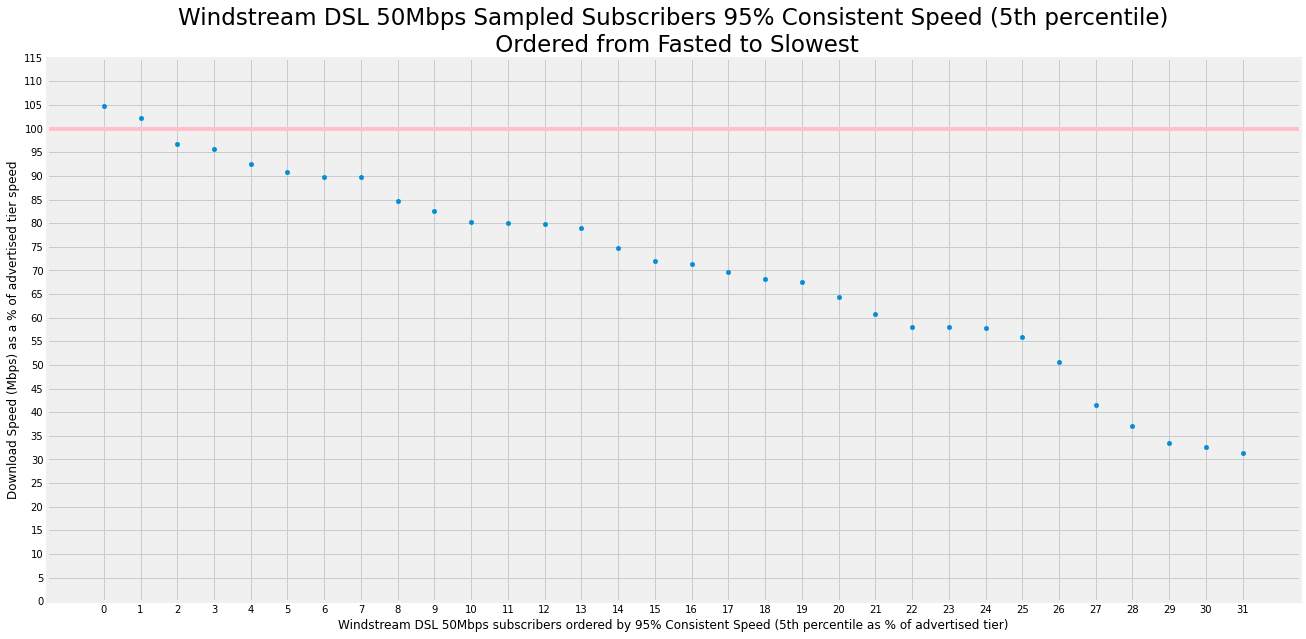

In [207]:
x=[]
for i in range(len(windstream50Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = windstream50Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 120, 5))
plt.xticks(np.arange(0, len(windstream50Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Windstream DSL 50Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Windstream DSL 50Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [208]:
windstream100

,unit_id,ISP,Technology,Download,State,Census,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,5PctNorm,MedianNorm
0,10167,Windstream,DSL,100.0,KY,South,0,0,91.264944,109.683152,108.786136,91.264944,108.786136
1,40206337,Windstream,DSL,100.0,GA,South,0,0,102.447392,105.007528,104.829728,102.447392,104.829728
2,38616857,Windstream,DSL,100.0,GA,South,0,0,98.160352,104.994792,104.316536,98.160352,104.316536
3,41194973,Windstream,DSL,100.0,GA,South,0,0,99.530272,99.530272,99.530272,99.530272,99.530272
4,38616865,Windstream,DSL,100.0,GA,South,0,0,97.977392,104.766056,103.287056,97.977392,103.287056
5,999625,Windstream,DSL,100.0,TX,South,0,0,101.815376,109.803544,109.205248,101.815376,109.205248
6,32833353,Windstream,DSL,100.0,OK,South,0,0,85.255104,86.079520,86.044312,85.255104,86.044312
7,999221,Windstream,DSL,100.0,TX,South,0,0,92.588168,96.993168,96.589248,92.588168,96.589248
8,26226257,Windstream,DSL,100.0,TX,South,0,0,117.245896,118.423256,118.351912,117.245896,118.351912
9,26226325,Windstream,DSL,100.0,TX,South,0,0,81.166992,93.939936,92.698664,81.166992,92.698664


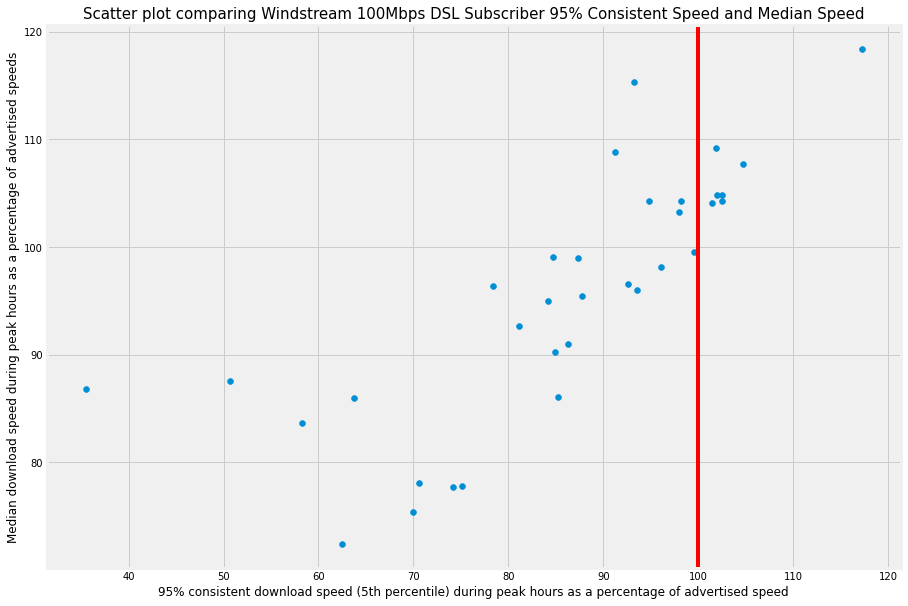

In [209]:
X =  windstream100Scatter['5PctNorm']
Y = windstream100Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Windstream 100Mbps DSL Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

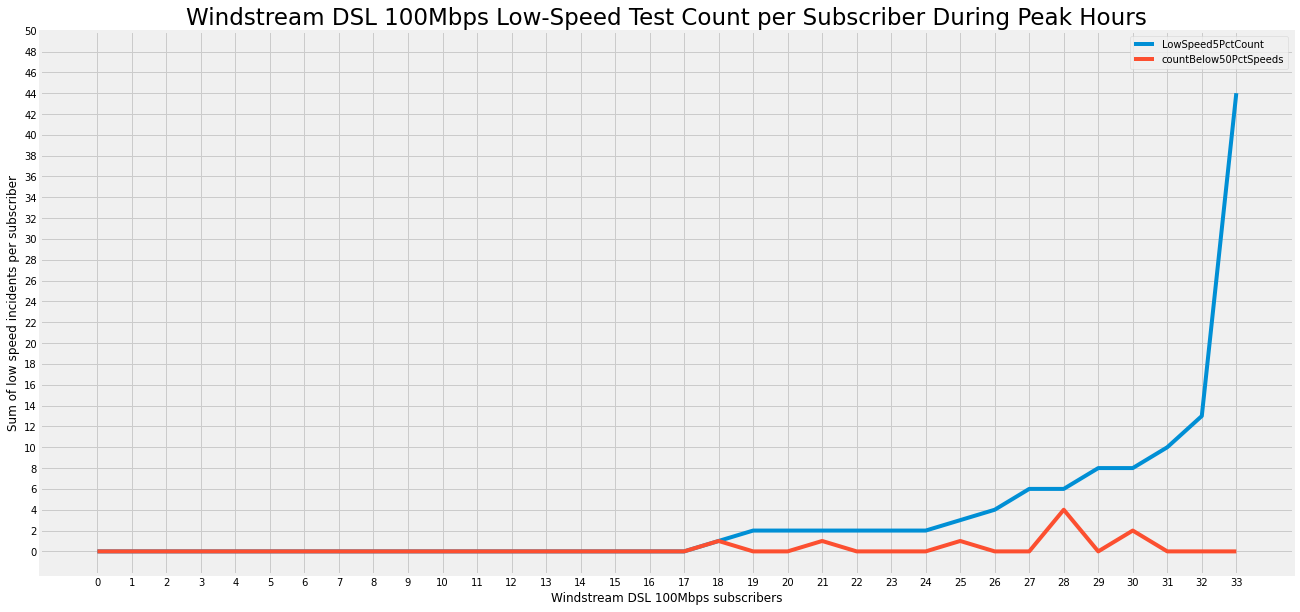

In [210]:
ax = windstream100.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 52, 2))
plt.xticks(np.arange(0, len(windstream100), 1))


ax.set_xlabel('Windstream DSL 100Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Windstream DSL 100Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [211]:
print(stats.kendalltau(windstream100['LowSpeed5PctCount'], windstream100['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(windstream100['LowSpeed5PctCount'], windstream100['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.33949025698194063, pvalue=0.01012443904559711)


SpearmanrResult(correlation=-0.44294775784484697, pvalue=0.008703355669781815)


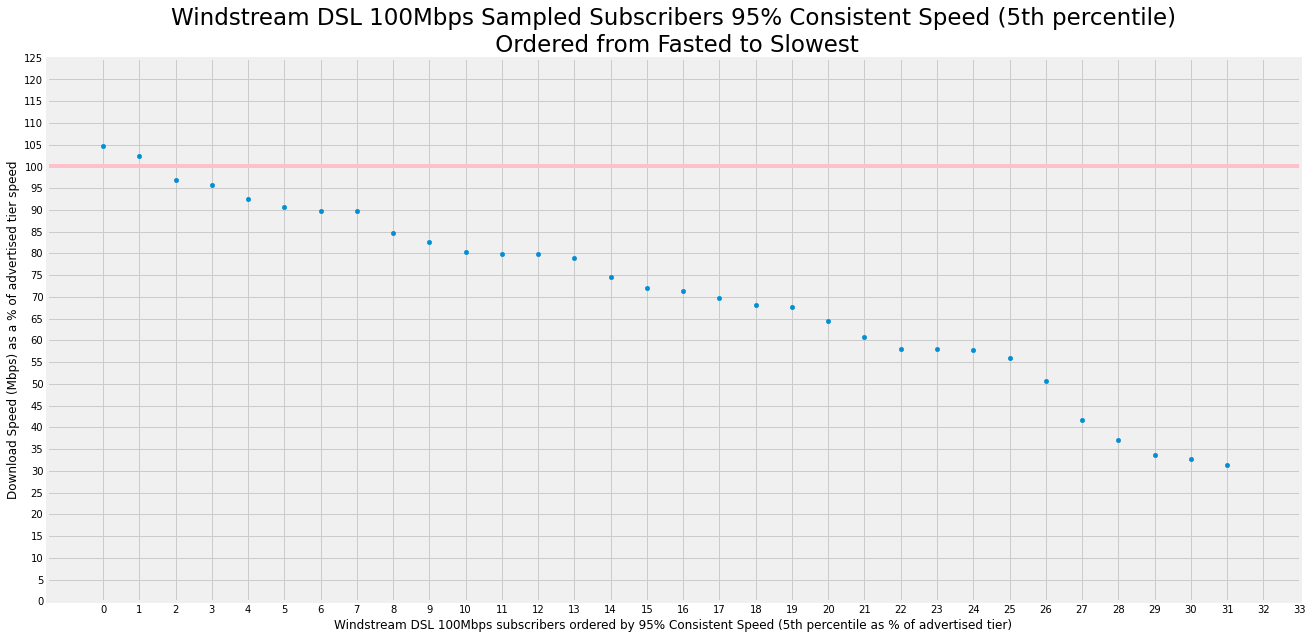

In [212]:
x=[]
for i in range(len(windstream50Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = windstream50Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 130, 5))
plt.xticks(np.arange(0, len(windstream100Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Windstream DSL 100Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Windstream DSL 100Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [213]:
mediacom500

,unit_id,ISP,Technology,Download,State,Census,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,5PctNorm,MedianNorm
0,39876973,Mediacom,Cable,500.0,IA,Midwest,0,0,545.434672,572.286600,571.158496,109.086934,114.231699
1,38513293,Mediacom,Cable,500.0,IL,Midwest,0,0,552.315512,570.932856,566.335896,110.463102,113.267179
2,26437521,Mediacom,Cable,500.0,MO,Midwest,0,0,548.032840,572.322704,571.345536,109.606568,114.269107
3,38658737,Mediacom,Cable,500.0,IA,Midwest,0,0,570.860992,571.236544,570.885464,114.172198,114.177093
4,38616913,Mediacom,Cable,500.0,IA,Midwest,0,0,515.437096,566.305240,559.623296,103.087419,111.924659
5,38513353,Mediacom,Cable,500.0,MN,Midwest,0,0,536.477112,572.181744,568.804512,107.295422,113.760902
6,38658733,Mediacom,Cable,500.0,MO,Midwest,0,0,554.161104,572.130520,569.262872,110.832221,113.852574
7,38513393,Mediacom,Cable,500.0,IA,Midwest,0,0,568.106528,571.289688,570.830112,113.621306,114.166022
8,38513533,Mediacom,Cable,500.0,IN,Midwest,0,0,556.905624,567.966584,562.447744,111.381125,112.489549
9,26827337,Mediacom,Cable,500.0,IA,Midwest,0,0,564.362160,571.368360,570.655536,112.872432,114.131107


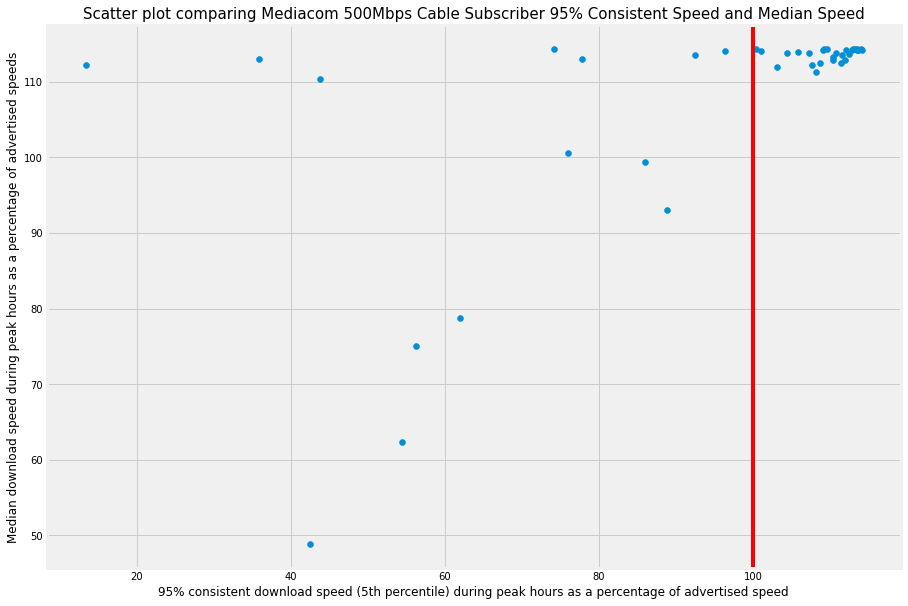

In [214]:
X =  mediacom500Scatter['5PctNorm']
Y = mediacom500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Mediacom 500Mbps Cable Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

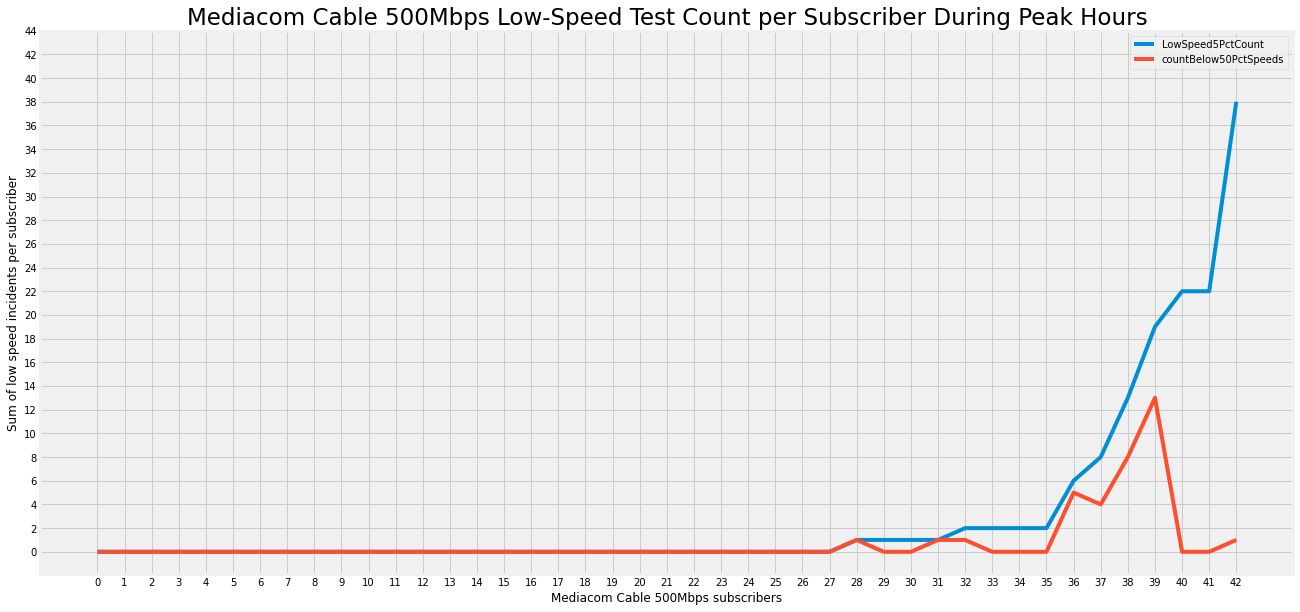

In [215]:
ax = mediacom500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 46, 2))
plt.xticks(np.arange(0, len(mediacom500), 1))


ax.set_xlabel('Mediacom Cable 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Mediacom Cable 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [216]:
print(stats.kendalltau(mediacom500['LowSpeed5PctCount'], mediacom500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(mediacom500['LowSpeed5PctCount'], mediacom500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.17648280200062935, pvalue=0.1381475024655372)


SpearmanrResult(correlation=-0.2465018165777769, pvalue=0.111050723327667)


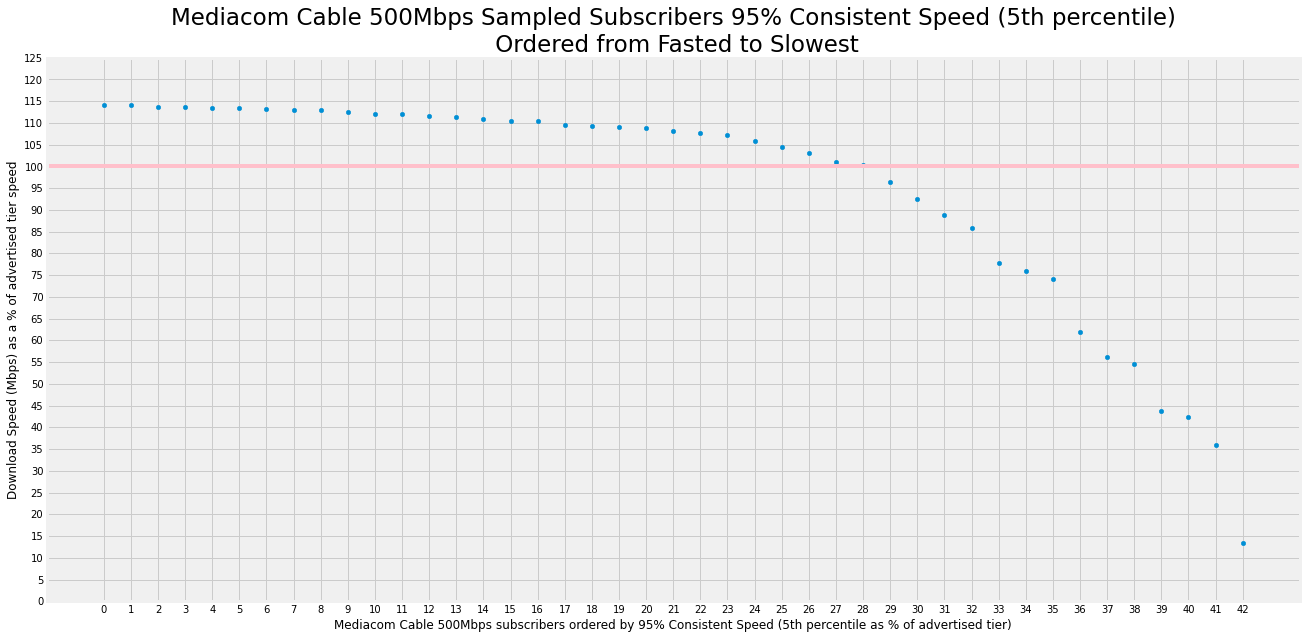

In [217]:
x=[]
for i in range(len(mediacom500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = mediacom500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 130, 5))
plt.xticks(np.arange(0, len(mediacom500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Mediacom Cable 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Mediacom Cable 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [218]:
comcast500

,unit_id,ISP,Technology,Download,State,Census,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,5PctNorm,MedianNorm
0,38713617,Comcast,Cable,500.0,CA,West,0,0,589.154120,596.241080,594.795600,117.830824,118.959120
1,38713301,Comcast,Cable,500.0,CA,West,0,0,592.538304,596.243288,595.272280,118.507661,119.054456
2,24030797,Comcast,Cable,500.0,CA,West,0,0,558.664856,596.192696,589.371288,111.732971,117.874258
3,24525689,Comcast,Cable,500.0,CA,West,0,0,589.179832,596.091816,595.196400,117.835966,119.039280
4,25834681,Comcast,Cable,500.0,CO,West,0,0,586.442024,595.284712,595.258656,117.288405,119.051731
5,24767593,Comcast,Cable,500.0,CA,West,0,0,592.428728,595.071392,592.432912,118.485746,118.486582
6,4114285,Comcast,Cable,500.0,OR,West,0,0,581.479968,596.556824,592.488792,116.295994,118.497758
7,24840645,Comcast,Cable,500.0,WA,West,0,0,389.582960,546.714472,505.428320,77.916592,101.085664
8,4040429,Comcast,Cable,500.0,WA,West,0,2,576.629080,597.113480,593.271264,115.325816,118.654253
9,25657945,Comcast,Cable,500.0,WA,West,0,0,446.949312,581.159448,537.783312,89.389862,107.556662


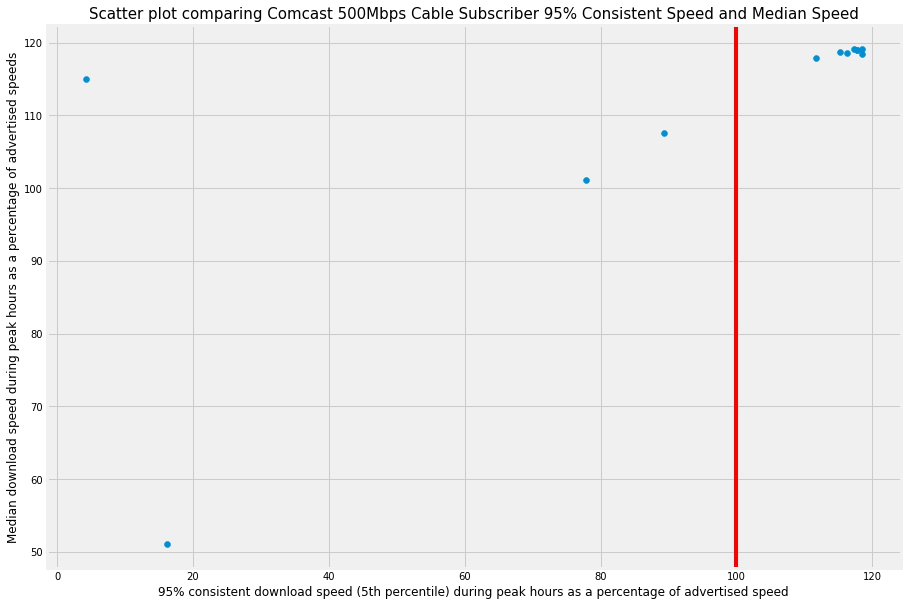

In [219]:
X =  comcast500Scatter['5PctNorm']
Y = comcast500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Comcast 500Mbps Cable Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

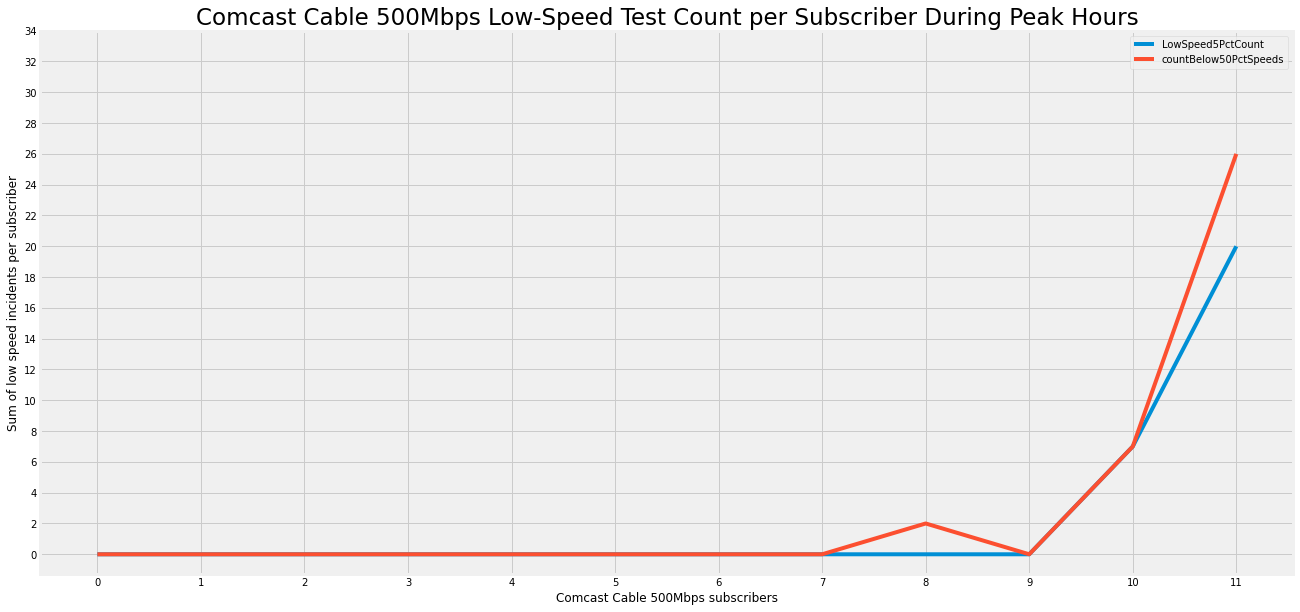

In [220]:
ax = comcast500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 36, 2))
plt.xticks(np.arange(0, len(comcast500), 1))

ax.set_xlabel('Comcast Cable 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Comcast Cable 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [221]:
print(stats.kendalltau(comcast500['LowSpeed5PctCount'], comcast500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(comcast500['LowSpeed5PctCount'], comcast500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.2954684201426394, pvalue=0.240062291152626)


SpearmanrResult(correlation=-0.38166527377477155, pvalue=0.22086746731076976)


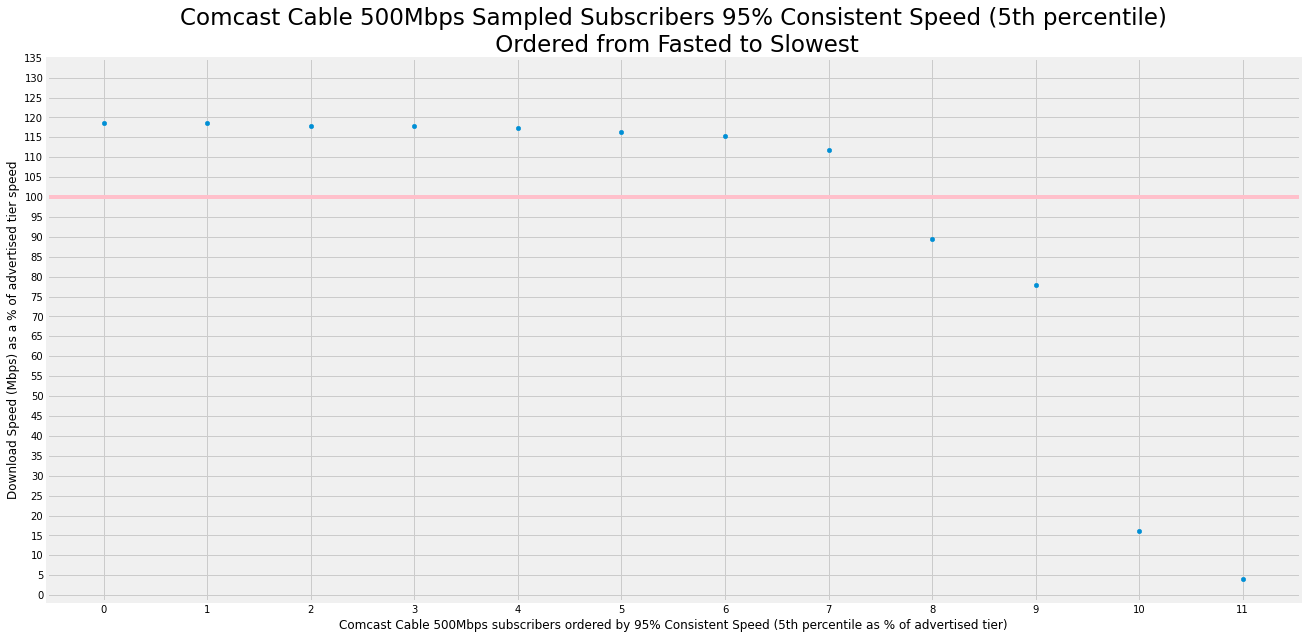

In [222]:
x=[]
for i in range(len(comcast500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = comcast500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 140, 5))
plt.xticks(np.arange(0, len(comcast500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Comcast Cable 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Comcast Cable 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()

In [223]:
frontier500

,unit_id,ISP,Technology,Download,State,Census,LowSpeed5PctCount,countBelow50PctSpeeds,slow5Pct,fastest95PctSpeedMbps,medianSpeedMbps,5PctNorm,MedianNorm
0,39774565,Frontier,Fiber,500.0,TX,South,0,0,497.512480,508.576024,505.973152,99.502496,101.194630
1,39876837,Frontier,Fiber,500.0,CA,West,0,0,498.071064,504.531296,499.652288,99.614213,99.930458
2,25886969,Frontier,Fiber,500.0,CA,West,0,0,480.822280,504.615456,500.343920,96.164456,100.068784
3,38098225,Frontier,Fiber,500.0,CA,West,0,0,495.230904,502.030752,501.060704,99.046181,100.212141
4,38098173,Frontier,Fiber,500.0,CA,West,0,0,494.850200,510.068568,509.524752,98.970040,101.904950
5,39876969,Frontier,Fiber,500.0,CA,West,0,0,501.963808,509.052136,507.789592,100.392762,101.557918
6,3894093,Frontier,Fiber,500.0,CA,West,0,0,477.180160,501.288152,493.550768,95.436032,98.710154
7,24839733,Frontier,Fiber,500.0,CA,West,0,0,495.938552,509.729520,503.123672,99.187710,100.624734
8,24839925,Frontier,Fiber,500.0,CA,West,0,0,488.114696,503.514880,498.926616,97.622939,99.785323
9,38407149,Frontier,Fiber,500.0,CA,West,0,0,489.919768,505.361448,504.884192,97.983954,100.976838


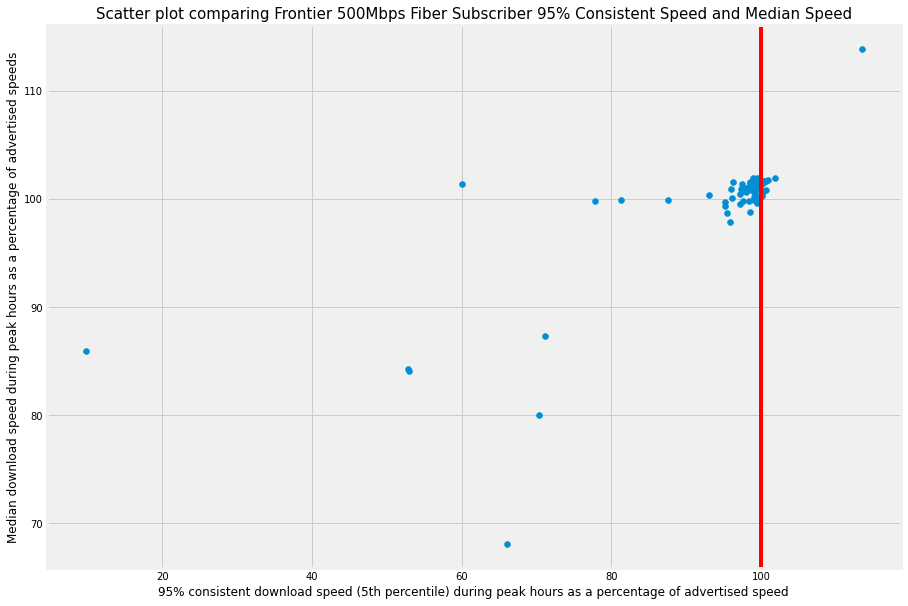

In [224]:
X =  frontier500Scatter['5PctNorm']
Y = frontier500Scatter['MedianNorm']

fig = plt.figure()
plt.rcParams["figure.figsize"] = [30, 10]
ax1 = fig.add_subplot(122)

ax1.scatter(X, Y)
plt.grid(True)

plt.axvline(x = 100, color = 'red', linestyle = '-')
plt.xlabel("95% consistent download speed (5th percentile) during peak hours as a percentage of advertised speed")
plt.ylabel("Median download speed during peak hours as a percentage of advertised speeds")
plt.title("Scatter plot comparing Frontier 500Mbps Fiber Subscriber 95% Consistent Speed and Median Speed",fontsize=15)


    
plt.show()

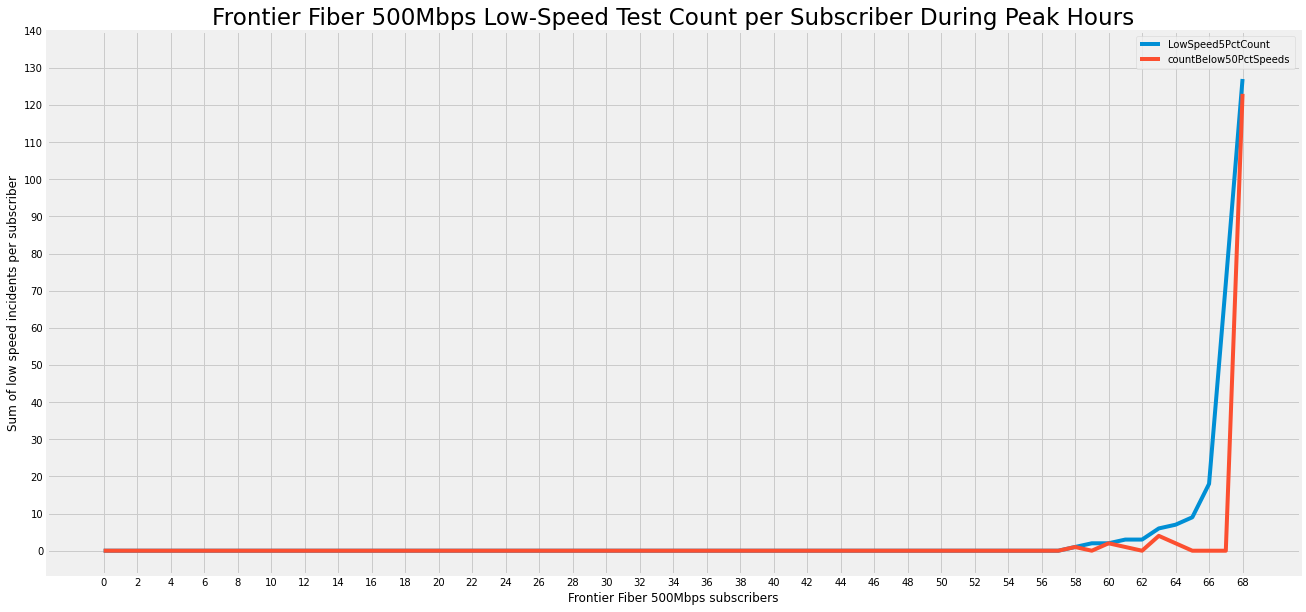

In [225]:
ax = frontier500.plot(y = ['LowSpeed5PctCount', 'countBelow50PctSpeeds'],  kind = 'line',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 150, 10))
plt.xticks(np.arange(0, len(frontier500), 2))

ax.set_xlabel('Frontier Fiber 500Mbps subscribers')
ax.set_ylabel('Sum of low speed incidents per subscriber')
ax.set_title('Frontier Fiber 500Mbps Low-Speed Test Count per Subscriber During Peak Hours', fontsize=23)


plt.show()

In [226]:
print(stats.kendalltau(frontier500['LowSpeed5PctCount'], frontier500['fastest95PctSpeedMbps']))
print('\n')
print(stats.spearmanr(frontier500['LowSpeed5PctCount'], frontier500['fastest95PctSpeedMbps']))

KendalltauResult(correlation=-0.2552585708713601, pvalue=0.008067503364372898)


SpearmanrResult(correlation=-0.3185803278694842, pvalue=0.007633117409186123)


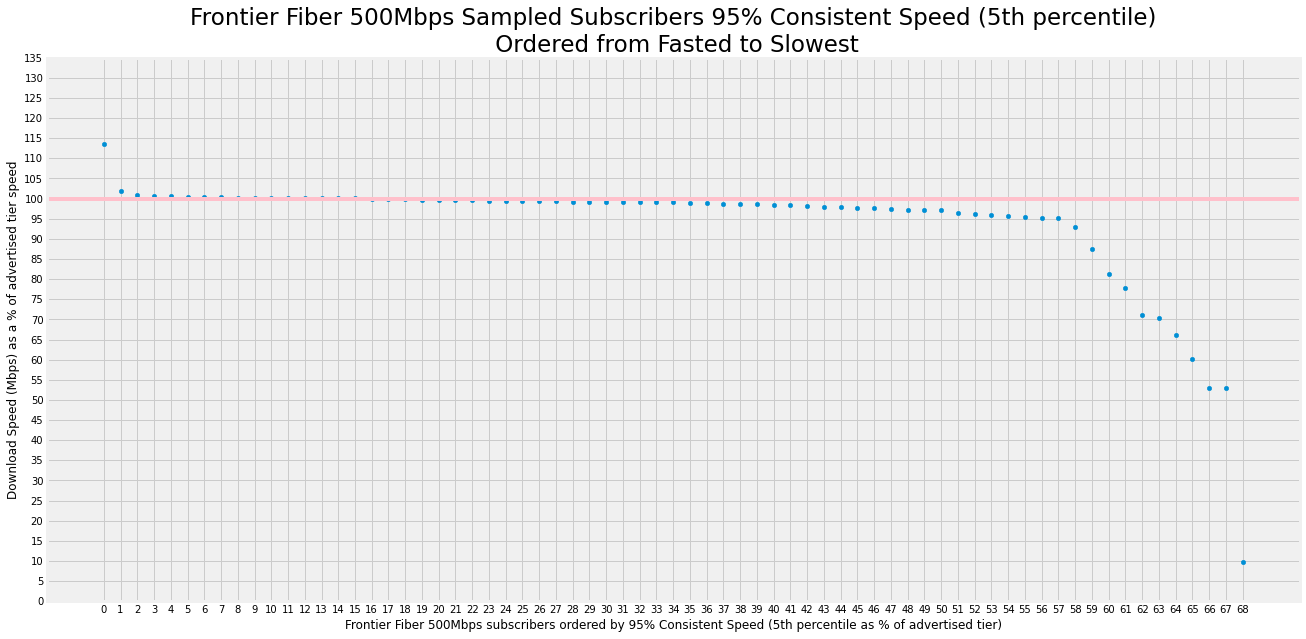

In [227]:
x=[]
for i in range(len(frontier500Scatter)):
    x.append(i)
    
chartData = pd.DataFrame()
chartData['5PctNorm'] = frontier500Scatter['5PctNorm']
chartData['Subscribers'] = x


ax = chartData.plot(x = ['Subscribers'] ,y = ['5PctNorm'],  kind = 'scatter',
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 5))
plt.xticks(np.arange(0, len(frontier500Scatter), 1))
plt.axhline(y = 100, color = 'pink', linestyle = '-')

ax.set_xlabel('Frontier Fiber 500Mbps subscribers ordered by 95% Consistent Speed (5th percentile as % of advertised tier)')
ax.set_ylabel('Download Speed (Mbps) as a % of advertised tier speed')
ax.set_title('Frontier Fiber 500Mbps Sampled Subscribers 95% Consistent Speed (5th percentile)\n Ordered from Fasted to Slowest', fontsize=23)


plt.show()